# **Data Preprocessing**

In [ ]:
import pandas as pd

data = pd.read_excel("Grammar Correction.xlsx")

data.head()

,Serial Number,Error Type,Ungrammatical Statement,Standard English
0,1,Verb Tense Errors,I goes to the store everyday.,I go to the store everyday.
1,2,Verb Tense Errors,They was playing soccer last night.,They were playing soccer last night.
2,3,Verb Tense Errors,She have completed her homework.,She has completed her homework.
3,4,Verb Tense Errors,He don't know the answer.,He doesn't know the answer.
4,5,Verb Tense Errors,The sun rise in the east.,The sun rises in the east.


In [ ]:
data.isnull().sum()

,0
Serial Number,0
Error Type,0
Ungrammatical Statement,0
Standard English,0


In [ ]:
inputs = data['Ungrammatical Statement']
outputs = data['Standard English']

for i in range(5):
    print(f"Input: {inputs[i]} -> Output: {outputs[i]}")


Input: I goes to the store everyday. -> Output: I go to the store everyday.
Input: They was playing soccer last night. -> Output: They were playing soccer last night.
Input: She have completed her homework. -> Output: She has completed her homework.
Input: He don't know the answer. -> Output: He doesn't know the answer.
Input: The sun rise in the east. -> Output: The sun rises in the east.


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_inputs = [tokenizer.tokenize(sent) for sent in inputs]
tokenized_outputs = [tokenizer.tokenize(sent) for sent in outputs]

print(tokenized_inputs[:5])
print(tokenized_outputs[:5])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[['i', 'goes', 'to', 'the', 'store', 'everyday', '.'], ['they', 'was', 'playing', 'soccer', 'last', 'night', '.'], ['she', 'have', 'completed', 'her', 'homework', '.'], ['he', 'don', "'", 't', 'know', 'the', 'answer', '.'], ['the', 'sun', 'rise', 'in', 'the', 'east', '.']]
[['i', 'go', 'to', 'the', 'store', 'everyday', '.'], ['they', 'were', 'playing', 'soccer', 'last', 'night', '.'], ['she', 'has', 'completed', 'her', 'homework', '.'], ['he', 'doesn', "'", 't', 'know', 'the', 'answer', '.'], ['the', 'sun', 'rises', 'in', 'the', 'east', '.']]


# **Exploratory Data Analysis (EDA):**

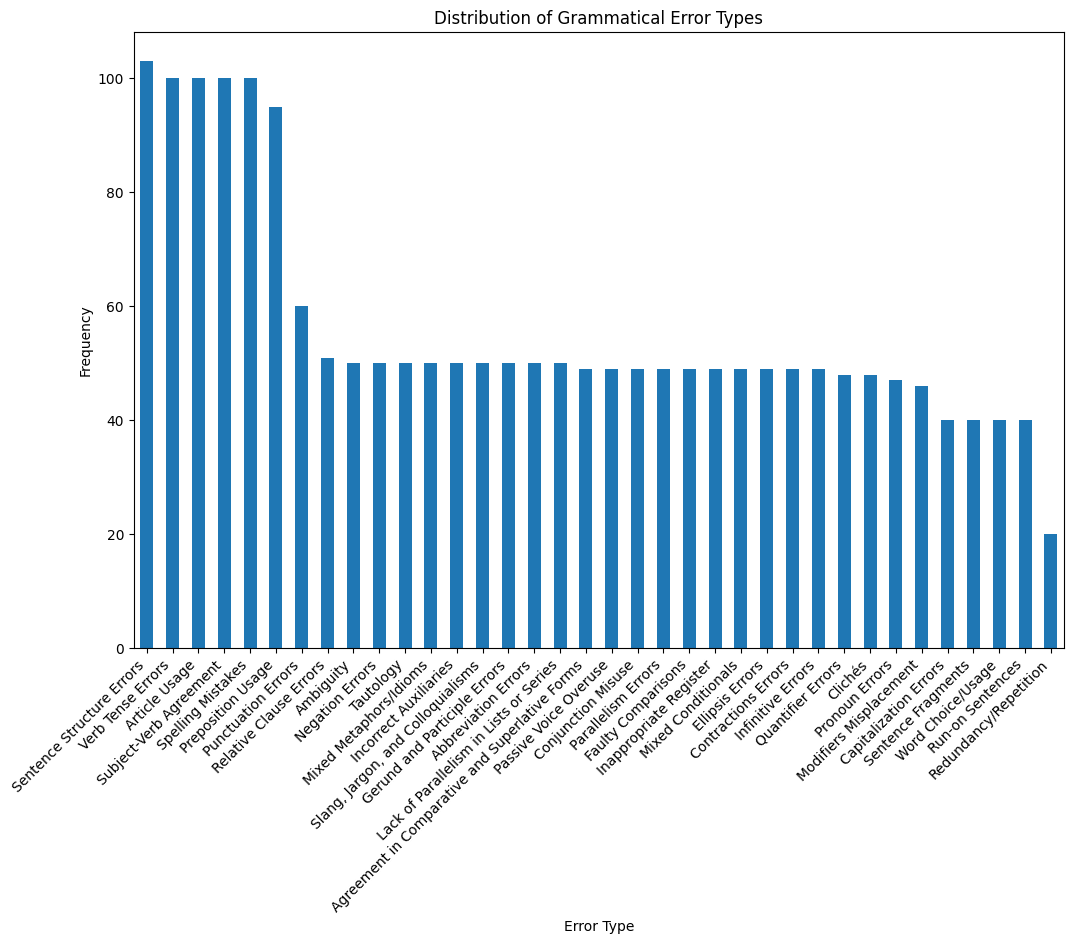

In [ ]:
import matplotlib.pyplot as plt

error_counts = data['Error Type'].value_counts()

# Plot the distribution of error types
plt.figure(figsize=(12, 8))
error_counts.plot(kind='bar')
plt.title('Distribution of Grammatical Error Types')
plt.xlabel('Error Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


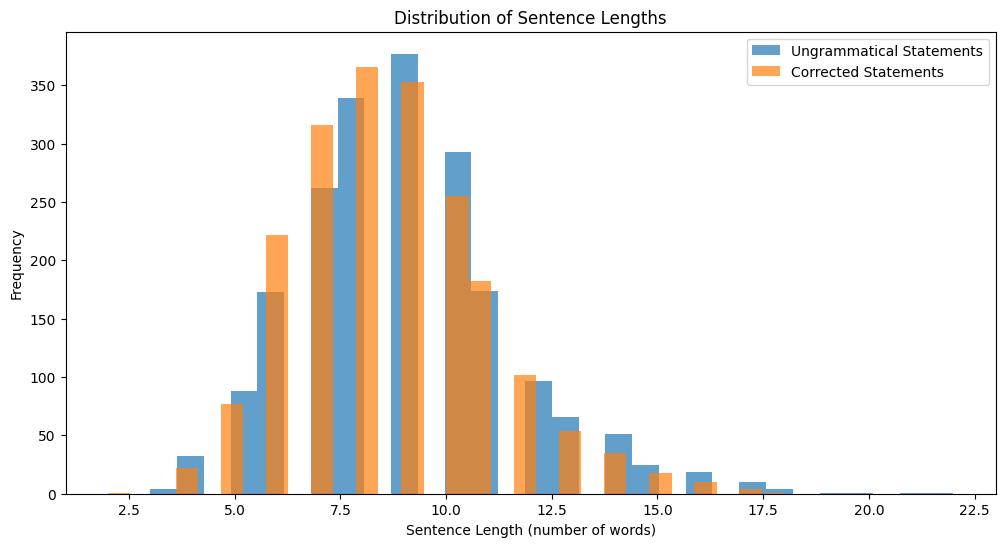

In [ ]:
input_lengths = data['Ungrammatical Statement'].apply(lambda x: len(x.split()))
output_lengths = data['Standard English'].apply(lambda x: len(x.split()))

# Plot the distribution of sentence lengths
plt.figure(figsize=(12, 6))
plt.hist(input_lengths, bins=30, alpha=0.7, label='Ungrammatical Statements')
plt.hist(output_lengths, bins=30, alpha=0.7, label='Corrected Statements')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length (number of words)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# **Baseline Machine Learning Model (LSTM):**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(data['Ungrammatical Statement']) + list(data['Standard English']))

input_sequences = tokenizer.texts_to_sequences(data['Ungrammatical Statement'])
output_sequences = tokenizer.texts_to_sequences(data['Standard English'])

input_sequences = pad_sequences(input_sequences, padding='post')
output_sequences = pad_sequences(output_sequences, padding='post')

input_train, input_val, output_train, output_val = train_test_split(input_sequences, output_sequences, test_size=0.2, random_state=42)

decoder_input_data = pad_sequences([seq[:-1] for seq in output_sequences], maxlen=output_sequences.shape[1], padding='post')
decoder_output_data = pad_sequences([seq[1:] for seq in output_sequences], maxlen=output_sequences.shape[1], padding='post')


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.optimizers import Adam

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
lstm_units = 256

# Define the model architecture
input_layer = Input(shape=(None,))
embedding_layer = Embedding(vocab_size, embedding_dim)(input_layer)

# Encoder
encoder_lstm = LSTM(lstm_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(embedding_layer)
encoder_states = [state_h, state_c]

# Decoder
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(vocab_size, embedding_dim)(decoder_inputs)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
output_layer = decoder_dense(decoder_outputs)

model = Model([input_layer, decoder_inputs], output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 100)      │        366,800 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 100)      │        366,800 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 256), (None,   │        365,568 │ embedding_1[0][0]      │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 256),    │        365,568 │ embedding_2[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 3668)     │        942,676 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,407,412 (9.18 MB)

 Trainable params: 2,407,412 (9.18 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

decoder_input_data_train, decoder_input_data_val = train_test_split(decoder_input_data, test_size=0.3, random_state=42)
decoder_output_data_train, decoder_output_data_val = train_test_split(decoder_output_data, test_size=0.5, random_state=42)

# Training the model
model.fit([input_train, decoder_input_data_train], np.expand_dims(decoder_output_data_train, -1),
          validation_data=([input_val, decoder_input_data_val], np.expand_dims(decoder_output_data_val, -1)),
          epochs=20, batch_size=64)


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6099 - loss: 2.4133 - val_accuracy: 0.6139 - val_loss: 2.7992
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.6109 - loss: 2.3980 - val_accuracy: 0.6137 - val_loss: 2.7969
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6110 - loss: 2.3635 - val_accuracy: 0.6156 - val_loss: 2.7896
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6193 - loss: 2.2931 - val_accuracy: 0.6134 - val_loss: 2.7920
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6250 - loss: 2.2533 - val_accuracy: 0.6162 - val_loss: 2.7939
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6193 - loss: 2.2676 - val_accuracy: 0.6178 - val_loss: 2.7922
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6290 - loss: 2.1915 - val_accuracy: 0.6167 - val_loss: 2.7906
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6331 - loss: 2.1513 - val_accuracy: 0.6207 - v

In [ ]:
scores = model.evaluate([input_val, decoder_input_data_val], np.expand_dims(decoder_output_data_val, -1))
print(f"Accuracy: {scores[1]*100}%")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6241 - loss: 2.8819
Accuracy: 62.89879083633423%


# **Generative AI Enhancement:**

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

def build_text_file(data, filename):
    with open(filename, 'w') as f:
        for input, output in zip(data['Ungrammatical Statement'], data['Standard English']):
            f.write(input + " [SEP] " + output + " [EOS]\n")

build_text_file(data, 'train_dataset.txt')

train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path='train_dataset.txt',
    block_size=128
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

training_args = TrainingArguments(
    output_dir='./gpt2-finetuned-grammar',
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Step,Training Loss
500,1.129300
1000,0.694900


TrainOutput(global_step=1200, training_loss=0.8567289161682129, metrics={'train_runtime': 233.9283, 'train_samples_per_second': 20.519, 'train_steps_per_second': 5.13, 'total_flos': 313550438400000.0, 'train_loss': 0.8567289161682129, 'epoch': 10.0})

In [ ]:
model.save_pretrained('./gpt2-finetuned-grammar')
tokenizer.save_pretrained('./gpt2-finetuned-grammar')

('./gpt2-finetuned-grammar/tokenizer_config.json',
 './gpt2-finetuned-grammar/special_tokens_map.json',
 './gpt2-finetuned-grammar/vocab.json',
 './gpt2-finetuned-grammar/merges.txt',
 './gpt2-finetuned-grammar/added_tokens.json')

In [ ]:
def extract_correction(output):
    if '[SEP]' in output:
        return output.split('[SEP]')[1].split('[EOS]')[0].strip()
    return output

for text in ["She no went to the market.", "The cake needs to be baked in 350°F for 30 minutes."]:
    correction = generator(text, max_length=60, num_return_sequences=1, num_beams=5, truncation=True)
    corrected_text = extract_correction(correction[0]['generated_text'])
    print(f"Original: {text}\nCorrected: {corrected_text}\n")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Original: She no went to the market.
Corrected: She went to the market and bought groceries.

Original: The cake needs to be baked in 350°F for 30 minutes.
Corrected: The cake needs to be baked in 350°F for 30 minutes.



In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu(reference, hypothesis):
    reference = [ref.split() for ref in reference]
    hypothesis = hypothesis.split()
    return sentence_bleu(reference, hypothesis)

sample_text = "She no went to the market."
reference_text = ["She did not go to the market."]
generated_text = generator(sample_text, max_length=60, num_return_sequences=1, num_beams=5)[0]['generated_text']
bleu_score = calculate_bleu(reference_text, generated_text)
print(f"BLEU score: {bleu_score}")


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


BLEU score: 0.0641492151460376
